# Workshop 8 - Introduction to Deep Neural Networks

Code for workshop 8.  This will use Keras (within tensorflow v2) to build a small fully connected network. 

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os, time
import pandas as pd

# Our new Deep Learning imports
import tensorflow as tf
from tensorflow import keras

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns; sns.set()

In [2]:
# Check the versions are OK (both should be 2 or more)
print(tf.__version__)
print(keras.__version__)

2.2.0
2.3.0-tf


## Load data
We will use fashion MNIST, which is a set of small images (28x28) that contain 10 different fashion items - see below for class names and an example image.

In [3]:
# This is a built-in data for keras, so easily accessible
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [4]:
# Let's see how big it is
print(X_train_full.shape)
print(X_test.shape)
n_total = X_train_full.shape[0]

(60000, 28, 28)
(10000, 28, 28)


float64
float64
Coat


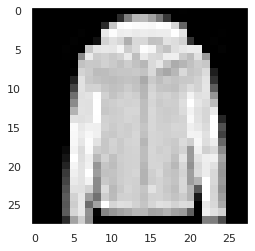

In [5]:
# Scale the data appropriately (it starts with max of 255, but we want max of 1)
# We will do this "by hand" here, but we could build a pipeline scaler for this instead
# We also split the training set given to us into training and validation subsets
#   The value of 5000 samples as the size of the validation set is an arbitrary choice
X_test = X_test/255.0
X_valid, X_train = X_train_full[:5000]/255.0, X_train_full[5000:]/255.0 
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
class_names = np.array([ "T-shirt/top" , "Trouser" , "Pullover" , "Dress" , "Coat" , "Sandal" , 
               "Shirt" , "Sneaker" , "Bag" , "Ankle boot" ])

# Inspect some aspects of the data (in general, you should play around with the data 
#                                   more than this to get a feel for it)
# Check that scaled types are appropriate
print(X_train.dtype)
print(X_valid.dtype)
# Look at first item
print(class_names[y_train[0]])
plt.imshow(X_train[0,:,:], cmap='gray')
plt.grid(False)
plt.show()

In [ ]:
# Let's look at the distribution of labels in the training, validation and test sets
plt.hist(y_train)
plt.show()
plt.hist(y_valid)
plt.show()
plt.hist(y_test)
plt.show()

## Simple Neural Network Code with Keras

We will use the keras version built into tensorflow version 2.
It is remarkably simple for building, training and evaluating networks.

In [ ]:
# This is *all* the code needed to define the network architecture
#  1 input layer + 2 hidden layers of sizes 300 and 100 + 1 output layer
model = keras.models.Sequential()   # This is a style of building networks - the easiest option
model.add(keras.layers.Flatten(input_shape = [28 , 28]))   # our inputs are 28 x 28 arrays, so need to become 1D
model.add(keras.layers.Dense(300, activation = "relu"))    # first hidden layer
model.add(keras.layers.Dense(100, activation = "relu"))    # second hidden layer
model.add(keras.layers.Dense(10, activation = "softmax"))  # output layer

In [ ]:
# Print out some info on the network - take note of the number of parameters (weights and biases)
# Can you calculate the number of parameters yourself?
model.summary()

In [ ]:
# Couple the architecture definition to a loss function and optimiser (and other performance metrics)
# Note that we use sparse_categorical_crossentropy because the entries in y_train are just numbers from 0 to 9
# If y_train was encoded as one-hot vectors, then the appropriate loss would be categorical_crossentropy instead
# We will use the SGD optimiser here, but Adam is another popular choice
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [ ]:
# Now train (fit) the model, specifying appropriate data and number of epochs (small here to save time)
# Save the history of metrics versus epochs - *always* keep this
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))

In [ ]:
# Simple way to plot the history information (see later for more detail)
pd.DataFrame(history.history).plot(figsize=(8 , 5))
plt.show()

In [ ]:
# Now run the model on the test set and get results (loss and accuracy both reported)
testres = model.evaluate(X_test, y_test, verbose=0)
print(testres)

In [ ]:
# We can inspect the output class predictions
y_pred = model.predict_classes(X_test[:3])  # use the first three test cases as an example
print(y_pred)   # predicted classes
print(class_names[y_pred])   # names of these classes (prediction)
print(class_names[y_test[:3]])   # names of true classes
# Display an image of the first test sample
plt.imshow(X_test[0].reshape((28,28)), cmap="gray")
plt.grid(False)

In [ ]:
# We can also look at the probability of predicting each class rather than the class with max probability
# Each row has ten probabilities (one per class)
y_proba = model.predict(X_test[:3])
print(y_proba.round(2))  # round to two decimal places when printing

In [ ]:
# We used many defaults, but we can find out what they are: e.g. learning rate is ...
print(keras.backend.eval(model.optimizer.lr))

# Now for a little more detail

For example, why make these particular choices for architecture and parameters.

We will set up some more general code so that we can build and compare a range of networks.

In [ ]:
# More general settings
# Let's allow the size of the training and validation sets to change
#n_train = n_total   # as above
#n_valid = 5000      # as above
n_train = 5000   # smaller set
n_valid = 1000
# Define the number and size of hidden layers
#hiddensizes = [300, 100]  # this was what we did above
hiddensizes = [100]   # instead, try a simpler one (only one layer)
# Define the activation function to be used by hidden layers
actfn = "relu"
# Optimiser and learning rate
optimizer = keras.optimizers.SGD
learningrate = 0.01
# Set size of batch and number of epochs
batch_size = 50
n_epochs = 20

In [ ]:
# Let's look at the distribution of labels in the training, validation and test sets we will use
plt.hist(y_train[:n_train])
plt.show()
plt.hist(y_valid[:n_valid])
plt.show()
plt.hist(y_test)
plt.show()

In [ ]:
# Build a more general model using various settings
def model_factory(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = [28 , 28]))    # always have same sized inputs
    for n in hiddensizes:
        model.add(keras.layers.Dense(n, activation = actfn))
    model.add(keras.layers.Dense(10, activation = "softmax"))   # always have 10 classes
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(lr=learningrate), metrics=["accuracy"])
    return model

In [ ]:
# Create our model
model = model_factory(hiddensizes, actfn, optimizer, learningrate)
# Show summary info
model.summary()
# Train it
history = model.fit(X_train[:n_train], y_train[:n_train], epochs=n_epochs, validation_data=(X_valid[:n_valid], y_valid[:n_valid]), 
                    batch_size=batch_size)

In [ ]:
# Plot the results (shifting validation curves appropriately)
plt.figure(figsize=(8,5))
plt.plot(np.arange(0,n_epochs),history.history['accuracy'], color='orange')
plt.plot(np.arange(0,n_epochs),history.history['loss'],'b')
plt.plot(np.arange(0,n_epochs)+0.5,history.history['val_accuracy'],'r')  # offset both validation curves
plt.plot(np.arange(0,n_epochs)+0.5,history.history['val_loss'],'g')
plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] 
plt.show() 

In [ ]:
# Display best accuracy on validation set
max_val_acc = np.max(history.history['val_accuracy'])
print(f'Best validation accuracy = {max_val_acc:.3f}')   # NB: .3f displays 3 decimal places
# Evaluate on testset
testres = model.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy on test set = {testres[1]:.3f}')

In [ ]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size):
    # Create our model
    model = model_factory(hiddensizes, actfn, optimizer, learningrate)
    # Train it
    history = model.fit(X_train[:n_train], y_train[:n_train], epochs=n_epochs, validation_data=(X_valid[:n_valid], y_valid[:n_valid]), 
                        batch_size=batch_size)
    max_val_acc = np.max(history.history['val_accuracy'])
    testres = model.evaluate(X_test, y_test, verbose=0)
    return (max_val_acc, testres[1], history)

In [ ]:
def random_model():
    # Make some random selections to see how performance varies with network size and training set size
    lsize=[10,100,1000]   # just have three options for layer sizes
    # start with three candidate layers
    hiddensizes = [lsize[np.random.randint(0,3)], lsize[np.random.randint(0,3)], lsize[np.random.randint(0,3)]]
    # then keep between 1 and 3 layers
    hiddensizes = hiddensizes[:np.random.randint(1,4)]
    n_train = np.random.randint(1,10)*10**np.random.randint(2,4)  # numbers between 100 and 9000 (logarithmically selected)
    n_epochs = 10  # to speed things up a bit (not recommended for proper evaluation)
    # Now build, run and report
    valacc, testacc, history = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
    print(f'Settings are: {(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)}')
    print(f'Validation accuracy = {valacc:.3f} and Test accuracy = {testacc:.3f}')
    print('Paste the following line into the workshop chat')
    retval = [hiddensizes, n_train, valacc, testacc]
    print(retval)
    return retval

In [ ]:
res = random_model()